In [1]:
import common
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import os, pathlib, enum
import json
from pathlib import Path
from sqlalchemy import text
from sqlalchemy.exc import IntegrityError
import psycopg2
import matplotlib.pyplot as plt
from IPython.display import Markdown

database = common.Database()
pcaps = pd.read_sql("SELECT * FROM pcap", database.engine)
malwares = pd.read_sql("SELECT * FROM malware", database.engine).set_index("id")

In [2]:
bdn = pd.read_sql("""
SELECT
    PCAP.MALWARE_ID,
    DN.DN,
    WL.RANK_BDN,
    COUNT(*) AS APP,
    SUM(CASE WHEN M.RCODE = 3 THEN 1 ELSE 0 END) AS NX,
    COUNT(DISTINCT M.PCAP_ID) AS PCAPS
FROM
    (SELECT * FROM MESSAGE WHERE IS_R is TRUE) AS M
    JOIN PCAP ON M.PCAP_ID = PCAP.ID
    JOIN DN ON M.DN_ID = DN.ID
    JOIN WHITELIST_DN WL ON WL.DN_ID = DN.ID
    WHERE
    PCAP.INFECTED is true AND PCAP.DATASET='CTU-13'
GROUP BY
    PCAP.MALWARE_ID,
    DN.DN,
    WL.RANK_BDN;
""", database.conn)

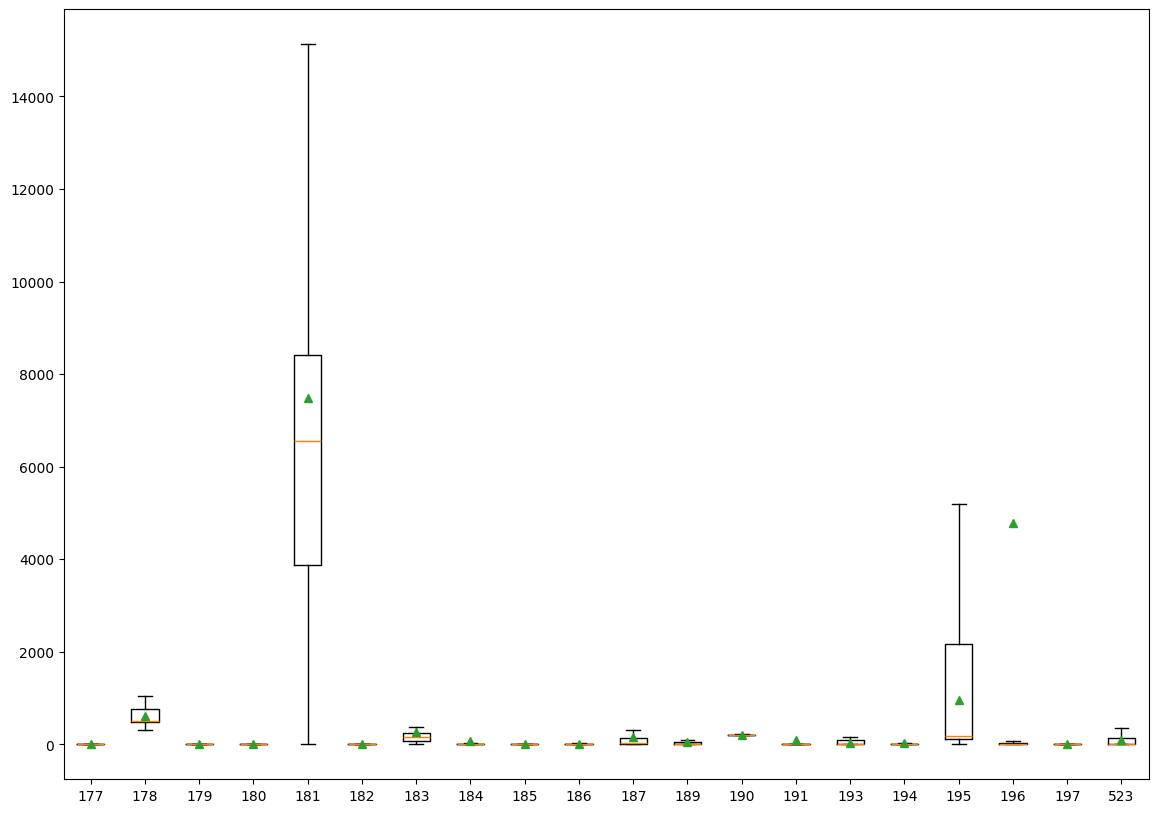

In [3]:

import matplotlib.pyplot as plt

col="app"
q_slot = bdn.copy()[[col, "malware_id"]].groupby(["malware_id"]).agg({col: lambda x: x.to_list()})
q_slot.reset_index(inplace=True)

# display(q_slot)
# q_slot = q_slot.pivot(index="mwid", columns="dga", values=["q", col])

y = []
x = []
labels=[]
i=0
for _, row in q_slot.iterrows():
    # print(row["malware_id"], "\n\n\n", row["app"])
    y.append(row["app"])
    labels.append(row["malware_id"])
    x.append(i)
    i += 1
    pass

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()
boxs = ax.boxplot(y,
                  tick_labels=labels,
                  positions=x,
                  showmeans=True,
                  meanline=False,
                  showfliers=False
                )

,malware_id,dn,rank_bdn,app,nx,pcaps
3169,179,bgfppdbann.so,NaN,2,2,1
3174,179,bichyoohicrodfv.de,NaN,2,2,1
3242,179,bwagbiy.tv,NaN,2,2,1
3247,179,bwqxumcuh.cm,NaN,2,2,1
3299,179,cixpyoskuds.mn,NaN,2,2,1
...,...,...,...,...,...,...
5615,179,yjaqmtycxsbobimkliaw.ki,NaN,2,2,1
5663,179,yspiiym.ru,NaN,2,2,1
5668,179,ytvvwjsxmsctrjavwrsp.mn,NaN,2,2,1
5674,179,yvmxwvtfj.eu,NaN,2,2,1


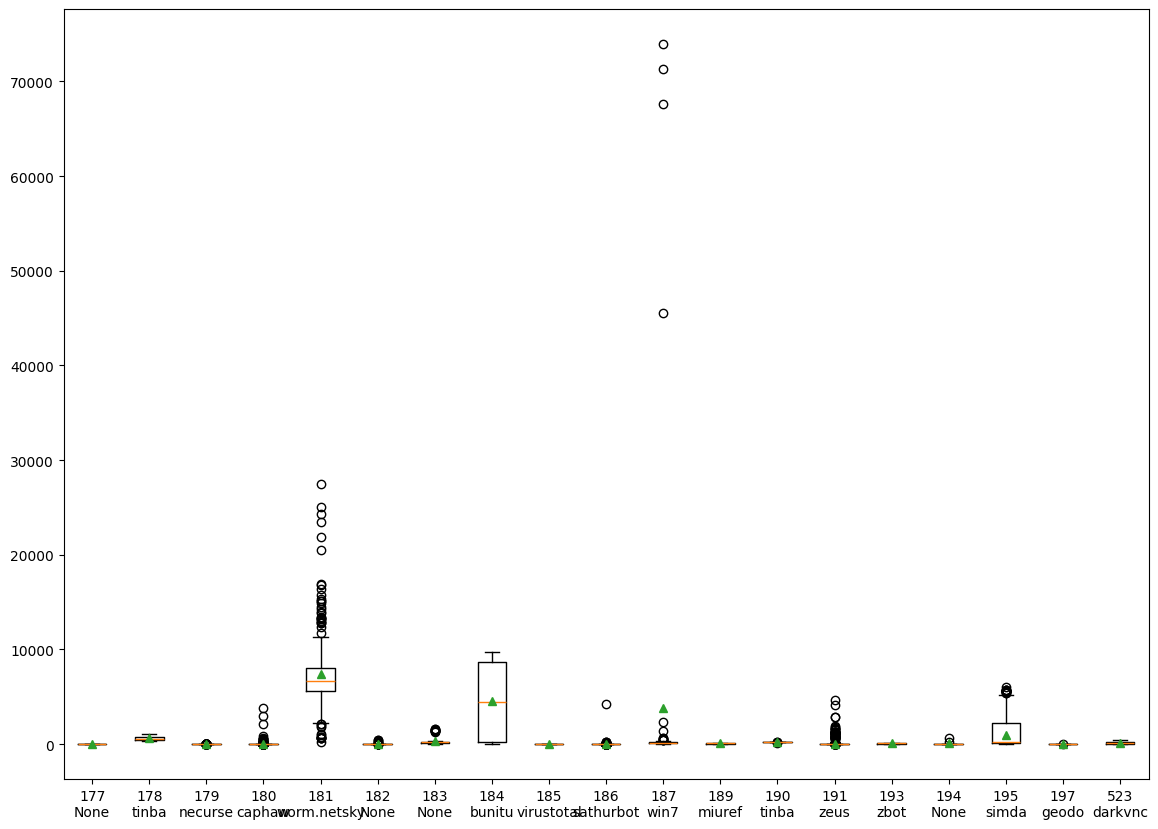

In [4]:
# BDN having rankbdn NULL


import matplotlib.pyplot as plt

col="app"
df = bdn[(bdn["rank_bdn"].isna()) & (bdn["nx"] > 0)].copy()
q_slot = df[[col, "malware_id"]].groupby(["malware_id"]).agg({col: lambda x: x.to_list()})
q_slot.reset_index(inplace=True)

# display(q_slot)
# q_slot = q_slot.pivot(index="mwid", columns="dga", values=["q", col])

y = []
x = []
labels=[]
i=0
for _, row in q_slot.iterrows():
    # print(row["malware_id"], "\n\n\n", row["app"])
    y.append(row["app"])
    labels.append(f"%s\n%s" % (row["malware_id"], malwares.loc[row["malware_id"], "name"]))
    x.append(i)
    i += 1
    pass

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()
boxs = ax.boxplot(y,
                  tick_labels=labels,
                  positions=x,
                  showmeans=True,
                  meanline=False,
                  showfliers=True
                )

# display(df[(df["malware_id"] == 187) & (df["nx"] > 10)])

# display(df[(df["malware_id"] == 184) & (df["nx"] > 10)])

# display(df[(df["malware_id"] == 181) & (df["nx"] > 10)])

# display(df[(df["malware_id"] == 196) & (df["nx"] > 10)])

display(df[(df["malware_id"] == 179) & (df["nx"] > 1)])

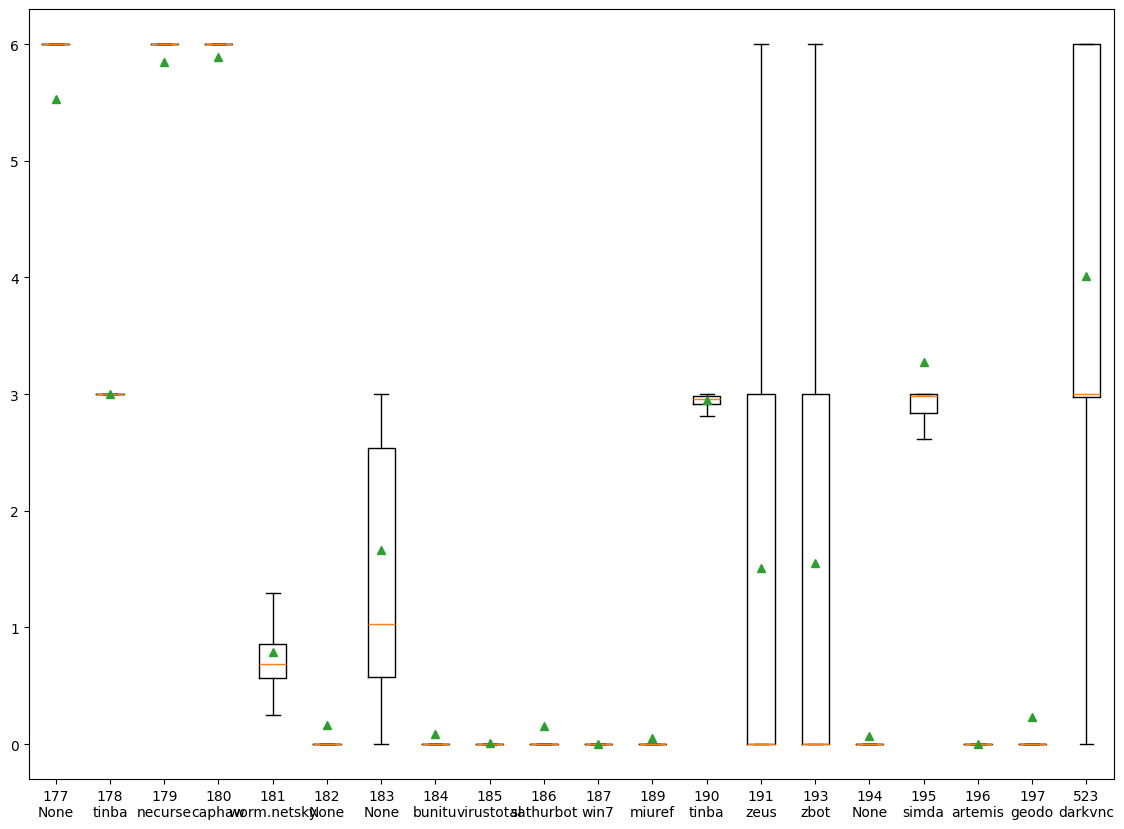

In [5]:
# BDN having rankbdn NULL


import matplotlib.pyplot as plt
import numpy as np
import math

col="w * nx/app"
# df = bdn[(bdn["rank_bdn"].isna()) & (bdn["nx"] > 0)].copy()

mask = (bdn["rank_bdn"].isna())

# mask &= (bdn["malware_id"] != 183)
# mask &= (bdn["malware_id"] != 195)
# mask &= (bdn["malware_id"] != 178)
# mask &= (bdn["malware_id"] != 181)

def weight(row):
    app, nx, rank_bdn = row["app"], row["nx"], row["rank_bdn"]
    if app > 10: w_app = 1
    else: w_app = 2
    if math.isnan(rank_bdn): w_rank = 1.5
    else: w_rank = 1
    r = nx/app
    if r > 0.75: w_nx = 2
    elif r > 0.5: w_nx = 1.5
    elif r > 0.1: w_nx = 1.2
    else: w_nx = 1
    return w_rank * w_nx * w_app

df = bdn[mask].copy()
df["nx/app"] = df["nx"] / df["app"]
dfg = df[["malware_id", "app"]].groupby("malware_id").sum().reset_index()
df = df.merge(dfg, right_on="malware_id", left_on="malware_id", suffixes=["", "_sum"])
dfg = df[["malware_id", "dn"]].groupby("malware_id").count().reset_index()
df = df.merge(dfg, right_on="malware_id", left_on="malware_id", suffixes=["", "_count"])

df["w1"] = df["app"] / df["app_sum"]
df["app_x_bdn_medio"] = df["app"] / df["dn_count"]
df["w2"] = (df["app"]/df["app_sum"]) * df["app_x_bdn_medio"]

df["w3"] = df.apply(weight, axis=1)

df[col] = df["nx/app"] * (df["w3"])
q_slot = df[[col, "malware_id"]].groupby(["malware_id"]).agg({col: lambda x: x.to_list()})
q_slot.reset_index(inplace=True)

# display(q_slot)
# q_slot = q_slot.pivot(index="mwid", columns="dga", values=["q", col])

y = []
x = []
labels=[]
i=0
for _, row in q_slot.iterrows():
    # print(row["malware_id"], "\n\n\n", row["app"])
    y.append(row[col])
    labels.append(f"%s\n%s" % (row["malware_id"], malwares.loc[row["malware_id"], "name"]))
    x.append(i)
    i += 1
    pass

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()
boxs = ax.boxplot(y,
                  tick_labels=labels,
                  positions=x,
                  showmeans=True,
                  meanline=False,
                  showfliers=False
                )

In [7]:

def weight(row):
    app, nx, rank_bdn = row["app"], row["nx"], row["rank_bdn"]
    if app > 10: w_app = 1
    else: w_app = 2
    if math.isnan(rank_bdn): w_rank = 1.5
    else: w_rank = 1
    r = nx/app
    if r > 0.75: w_nx = 2
    elif r > 0.5: w_nx = 1.5
    elif r > 0.1: w_nx = 1.2
    else: w_nx = 1
    return w_rank * w_nx * w_app

df = bdn.copy()
df["nx/app"] = df["nx"] / df["app"]
dfg = df[["malware_id", "app"]].groupby("malware_id").sum().reset_index()
df = df.merge(dfg, right_on="malware_id", left_on="malware_id", suffixes=["", "_sum"])
dfg = df[["malware_id", "dn"]].groupby("malware_id").count().reset_index()
df = df.merge(dfg, right_on="malware_id", left_on="malware_id", suffixes=["", "_count"])

df["w1"] = df["app"] / df["app_sum"]
df["app_x_bdn_medio"] = df["app"] / df["dn_count"]
df["w2"] = (df["app"]/df["app_sum"]) * df["app_x_bdn_medio"]

df["w3"] = df.apply(weight, axis=1)


In [8]:
mwlist = pcaps[(pcaps["dataset"] == "CTU-13")][["id", "malware_id"]].groupby("malware_id").agg({"id": lambda x: x.to_list()}).sort_values(by="malware_id")
mwdga = {}


def genmask(mwid, appgt10=None, nx_gt0=None, rankbdn_null=None, nx_app_gt=None, nx_app_lt=None):
    df = bdn.copy()
    df["nx/app"] = df["nx"] / df["app"]
    tmp = []
    mask = pd.Series(np.ones(df.shape[0], dtype=bool))
    if appgt10 is not None:
        tmp.append("app > 10" if appgt10 else "app <= 10")
        mask &= df.app > 10 if appgt10 else df.app <= 10
    if nx_gt0 is not None:
        tmp.append("nx > 0" if nx_gt0 else "nx == 0")
        mask &= df.nx > 0 if nx_gt0 else df.nx == 0
    if rankbdn_null is not None:
        tmp.append("rankbdn null" if rankbdn_null else " rankbdn not null")
        mask &= df.rank_bdn.isna() if rankbdn_null else (~df.rank_bdn.isna())
    if nx_app_gt is not None:
        tmp.append(f"nx/app > {nx_app_gt}")
        mask &= df["nx/app"] > nx_app_gt
    if nx_app_lt is not None:
        tmp.append(f"nx/app < {nx_app_lt}")
        mask &= df["nx/app"] < nx_app_lt
    label= " & ".join(tmp)
    df = df[(df.malware_id == mwid) & mask]
    display(Markdown("- " + "\n- ".join(tmp + [f"count: {df.shape[0]}"]))) # f"- {label}:  count={df.shape[0]}"))
    if df.shape[0]:
        display(df.sort_values(by="app", ascending=False))#.iloc[[0,1,2,3,-3,-2,-1]])
    return df

mwlist

,id
malware_id,
1,"[15, 18, 23, 11, 9, 19, 21, 17, 22, 10, 14, 20..."
177,[57]
178,[37]
179,[41]
180,[54]
181,"[44, 43]"
182,[34]
183,[27]
184,[36]


In [9]:
mwid = 177
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, appgt10=False, nx_app_lt=0.2)
genmask(mwid, appgt10=False, nx_app_gt=0.8)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "There are domains very DGA-like"
    ],
    "dga": 2
}

# 177

-  rankbdn not null
- count: 14

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
257,177,dns.msftncsi.com,453160.0,29,3,1,0.103448
1765,177,www.bing.com,156.0,17,1,1,0.058824
1766,177,www.google.com,3.0,14,8,1,0.571429
1767,177,www.google.cz,3963.0,14,8,1,0.571429
29,177,aol.com,1820.0,3,0,1,0.000000
578,177,hotmail.com,3910.0,3,0,1,0.000000
1008,177,mx1.hotmail.com,3910.0,3,0,1,0.000000
1009,177,mx2.hotmail.com,3910.0,3,0,1,0.000000
1715,177,web.de,8448.0,3,0,1,0.000000
1880,177,yahoo.com,228.0,3,0,1,0.000000


- app <= 10
- nx/app < 0.2
- count: 46

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
1330,177,qpfarcrsdqkwgnbpdaivsczpydrw.com,NaN,7,1,1,0.142857
1001,177,mta7.am0.yahoodns.net,NaN,4,0,1,0.000000
578,177,hotmail.com,3910.0,3,0,1,0.000000
1715,177,web.de,8448.0,3,0,1,0.000000
1009,177,mx2.hotmail.com,3910.0,3,0,1,0.000000
1008,177,mx1.hotmail.com,3910.0,3,0,1,0.000000
1000,177,mta6.am0.yahoodns.net,NaN,3,0,1,0.000000
29,177,aol.com,1820.0,3,0,1,0.000000
1880,177,yahoo.com,228.0,3,0,1,0.000000
1769,177,www.lthnvbepjvworeawsvoozeagq.com,NaN,2,0,1,0.000000


- app <= 10
- nx/app > 0.8
- count: 1788

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
0,177,adedtppnnfmztussktlnbknkn.org,NaN,7,7,1,1.000000
886,177,lrtofahqzlvrsxsscdaykzuqs.info,NaN,7,6,1,0.857143
971,177,mjrkqsdikbdibqhqprwoplqkvkzyt.info,NaN,7,7,1,1.000000
964,177,mhealwgzlnfljmbmfiramtdttw.biz,NaN,7,7,1,1.000000
963,177,mfvcijdeyguhadxknzfqx.org,NaN,7,7,1,1.000000
...,...,...,...,...,...,...,...
501,177,haknbknizbbinqsgyuwlvdqoay.info,NaN,1,1,1,1.000000
1493,177,tghimrwcaelvxgllylwklrsbulgi.biz,NaN,1,1,1,1.000000
1604,177,uogyeqobdirxoxsaikfdscirmnbufy.com,NaN,1,1,1,1.000000
515,177,hbqvkdqkydxxxobyhetzdbamkr.info,NaN,1,1,1,1.000000


In [10]:
mwid = 178
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, appgt10=None, nx_app_gt=0.8)
genmask(mwid, appgt10=None, nx_app_lt=0.2)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "There are domains very DGA-like.",
    ],
    "dga": 2
}

# 178

-  rankbdn not null
- count: 1

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
2179,178,dns.msftncsi.com,453160.0,3,3,1,1.0


- nx/app > 0.8
- count: 1002

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
2034,178,bbtybrmepmru.xyz,NaN,1046,1046,1,1.0
2791,178,rkpiqcmmmbue.xyz,NaN,1031,1031,1,1.0
2563,178,jxihgmogkkgs.xyz,NaN,1029,1029,1,1.0
2047,178,bcxuxooveffi.xyz,NaN,1029,1029,1,1.0
2091,178,brbqlwsepmtm.xyz,NaN,1029,1029,1,1.0
...,...,...,...,...,...,...,...
2874,178,stqbynwckcsx.xyz,NaN,339,339,1,1.0
2906,178,uipojtchwbur.xyz,NaN,338,338,1,1.0
2794,178,rlkkethqqvbt.xyz,NaN,338,338,1,1.0
2086,178,bqumjrfosrqp.xyz,NaN,315,315,1,1.0


- nx/app < 0.2
- count: 0

In [11]:
# mwid = mwlist.index[2]
mwid = 179
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=False, appgt10=True)
genmask(mwid, rankbdn_null=False, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=None, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=True, appgt10=None, nx_app_lt=0.2)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn.",
        "There are many domains very DGA-like.",
    ],
    "dga": 2
}

# 179

-  rankbdn not null
- count: 17

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
3439,179,dns.msftncsi.com,453160.0,537,2,1,0.003724
3028,179,0.pool.ntp.org,21832.0,23,3,1,0.130435
3029,179,1.pool.ntp.org,21832.0,23,3,1,0.130435
3597,179,facebook.com,2.0,22,0,1,0.000000
3030,179,2.pool.ntp.org,21832.0,5,3,1,0.600000
3356,179,cvut.cz,71345.0,4,0,1,0.000000
3081,179,alt2.gmail-smtp-in.l.google.com,3.0,4,0,1,0.000000
3614,179,felk.cvut.cz,71345.0,4,0,1,0.000000
4395,179,microsoft.com,38.0,3,3,1,1.000000
3998,179,ip.tyk.nu,1125494.0,2,0,1,0.000000


- app > 10
-  rankbdn not null
- count: 4

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
3439,179,dns.msftncsi.com,453160.0,537,2,1,0.003724
3028,179,0.pool.ntp.org,21832.0,23,3,1,0.130435
3029,179,1.pool.ntp.org,21832.0,23,3,1,0.130435
3597,179,facebook.com,2.0,22,0,1,0.000000


- nx > 0
-  rankbdn not null
- count: 9

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
3439,179,dns.msftncsi.com,453160.0,537,2,1,0.003724
3028,179,0.pool.ntp.org,21832.0,23,3,1,0.130435
3029,179,1.pool.ntp.org,21832.0,23,3,1,0.130435
3030,179,2.pool.ntp.org,21832.0,5,3,1,0.600000
4395,179,microsoft.com,38.0,3,3,1,1.000000
5030,179,sso.anbtr.com,3529531.0,2,1,1,0.500000
3444,179,download.microsoft.com,38.0,1,1,1,1.000000
3763,179,gmail.com,299.0,1,1,1,1.000000
3778,179,google.com,3.0,1,1,1,1.000000


- rankbdn null
- nx/app > 0.8
- count: 2576

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
4012,179,iqtjwrkt.eu,NaN,2,2,1,1.0
5461,179,wxanndvinqrvfluw.org,NaN,2,2,1,1.0
4619,179,ojgelxxggvhkocr.sh,NaN,2,2,1,1.0
3675,179,frjuorqbhfhguklyjre.xxx,NaN,2,2,1,1.0
3676,179,frkapwhnotiytyd.ac,NaN,2,2,1,1.0
...,...,...,...,...,...,...,...
3936,179,icdvvugfns.eu,NaN,1,1,1,1.0
3937,179,icfvnisevkrskwdj.pw,NaN,1,1,1,1.0
3938,179,icgdhalsxvrfhdiae.org,NaN,1,1,1,1.0
3939,179,ichlmgvxpsw.ki,NaN,1,1,1,1.0


- rankbdn null
- nx/app < 0.2
- count: 59

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
3192,179,bllewbrb.bit,NaN,690,0,1,0.0
5597,179,ygwnfft.sh,NaN,569,0,1,0.0
4911,179,rlbdexogfcup.com,NaN,16,0,1,0.0
5360,179,vynohaopp.pw,NaN,6,0,1,0.0
5502,179,xioojeod.com,NaN,6,0,1,0.0
4669,179,oxqmjsmrdrlartl.eu,NaN,6,0,1,0.0
4440,179,msifvgfppduxed.com,NaN,2,0,1,0.0
5418,179,wokqirinoxkh.pw,NaN,2,0,1,0.0
5022,179,sqaaecdbo.sx,NaN,2,0,1,0.0
4001,179,ipobkudckmusk.tw,NaN,2,0,1,0.0


In [12]:
# mwid = mwlist.index[3]
mwid = 180
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=False, appgt10=None)
genmask(mwid, rankbdn_null=False, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=None, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=True, appgt10=None, nx_app_lt=0.2)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "There are many domains very DGA-like.",
    ],
    "dga": 2
}

# 180

-  rankbdn not null
- count: 2

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
7788,180,dns.msftncsi.com,453160.0,1274,108,1,0.084772
10817,180,www.download.windowsupdate.com,109464.0,890,0,1,0.000000


-  rankbdn not null
- count: 2

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
7788,180,dns.msftncsi.com,453160.0,1274,108,1,0.084772
10817,180,www.download.windowsupdate.com,109464.0,890,0,1,0.000000


- nx > 0
-  rankbdn not null
- count: 1

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
7788,180,dns.msftncsi.com,453160.0,1274,108,1,0.084772


- rankbdn null
- nx/app > 0.8
- count: 5496

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
6949,180,7v0b7144gfkwqpdk.smis.cc,NaN,121,121,1,1.0
7069,180,8n0553cb9uqaw.pcg.su,NaN,121,121,1,1.0
8736,180,jux1f4ixxa4ppkff.smis.cc,NaN,118,118,1,1.0
5735,180,09eguw3gi0dt2jfpz.pcg.su,NaN,116,116,1,1.0
6772,180,6q5m33o7ymp7kzb.ccl.su,NaN,108,108,1,1.0
...,...,...,...,...,...,...,...
7597,180,cgc1wfk05bzc8o0vt.smis.cc,NaN,1,1,1,1.0
7596,180,cgb2tnu5qjbc8.ccl.su,NaN,1,1,1,1.0
7595,180,cg1z0dvmog7p3d43.smis.cc,NaN,1,1,1,1.0
7594,180,cfj5ef.pcg.su,NaN,1,1,1,1.0


- rankbdn null
- nx/app < 0.2
- count: 77

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
10148,180,smis.cc,NaN,3779,564,1,0.149246
9606,180,pcg.su,NaN,2996,512,1,0.170895
7347,180,amia.cc,NaN,600,111,1,0.185000
8834,180,kirr.cc,NaN,571,70,1,0.122592
10124,180,sito.su,NaN,494,83,1,0.168016
...,...,...,...,...,...,...,...
8407,180,hm196p.jcy.su,NaN,1,0,1,0.000000
8231,180,ggdqe87wz2s.leq.su,NaN,1,0,1,0.000000
7702,180,d46yp7lvml0rm.smis.cc,NaN,1,0,1,0.000000
7357,180,aq3v228.leq.su,NaN,1,0,1,0.000000


In [13]:
# mwid = mwlist.index[4]
mwid = 181
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=False, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_lt=0.2)
genmask(mwid, rankbdn_null=True, appgt10=True, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=False, appgt10=True, nx_app_lt=0.5)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_lt=0.5)
genmask(mwid, rankbdn_null=None, appgt10=False, nx_app_lt=None)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s, many of them have thousands of appereances with an nx/app > 0.1.",
        "No domains very DGA-like.",
        "Seems to use composed domains, like dynamic-dns and a not very _fanciful_ subdomain.",
        "There are no domains apperead less than 10 times."
    ],
    "dga": 1
}

# 181

-  rankbdn not null
- count: 366

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
11504,181,gmail.com,299.0,147771,24612,2,0.166555
11515,181,hotmail.com,3910.0,46380,17758,2,0.382881
11372,181,apple.com,20.0,40942,5831,2,0.142421
11890,181,yahoo.com,228.0,40775,17158,2,0.420797
11476,181,example.com,128.0,36869,9670,2,0.262280
...,...,...,...,...,...,...,...
11377,181,aserp2020.oracle.com,375.0,138,23,2,0.166667
11858,181,userp2030.oracle.com,375.0,55,10,2,0.181818
11759,181,park-mx.above.com,2382328.0,53,4,2,0.075472
11860,181,userp2050.oracle.com,375.0,15,2,2,0.133333


- nx > 0
-  rankbdn not null
- count: 366

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
11504,181,gmail.com,299.0,147771,24612,2,0.166555
11515,181,hotmail.com,3910.0,46380,17758,2,0.382881
11372,181,apple.com,20.0,40942,5831,2,0.142421
11890,181,yahoo.com,228.0,40775,17158,2,0.420797
11476,181,example.com,128.0,36869,9670,2,0.262280
...,...,...,...,...,...,...,...
11377,181,aserp2020.oracle.com,375.0,138,23,2,0.166667
11858,181,userp2030.oracle.com,375.0,55,10,2,0.181818
11759,181,park-mx.above.com,2382328.0,53,4,2,0.075472
11860,181,userp2050.oracle.com,375.0,15,2,2,0.133333


- app <= 10
- rankbdn null
- nx/app > 0.8
- count: 0

- app <= 10
- rankbdn null
- nx/app < 0.2
- count: 0

- app > 10
- rankbdn null
- nx/app > 0.8
- count: 0

- app > 10
-  rankbdn not null
- nx/app < 0.5
- count: 324

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
11504,181,gmail.com,299.0,147771,24612,2,0.166555
11515,181,hotmail.com,3910.0,46380,17758,2,0.382881
11372,181,apple.com,20.0,40942,5831,2,0.142421
11890,181,yahoo.com,228.0,40775,17158,2,0.420797
11476,181,example.com,128.0,36869,9670,2,0.262280
...,...,...,...,...,...,...,...
11678,181,mx03.bancobsf.com.ar,5297339.0,166,44,2,0.265060
11377,181,aserp2020.oracle.com,375.0,138,23,2,0.166667
11858,181,userp2030.oracle.com,375.0,55,10,2,0.181818
11759,181,park-mx.above.com,2382328.0,53,4,2,0.075472


- app <= 10
- rankbdn null
- nx/app < 0.5
- count: 0

- app <= 10
- count: 0

In [14]:
# mwid = mwlist.index[5]
mwid = 182
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=None, nx_gt0=True)
genmask(mwid, rankbdn_null=False, nx_gt0=True)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_lt=0.2)
genmask(mwid, rankbdn_null=True, appgt10=True, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=False, appgt10=True, nx_app_lt=0.5)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_lt=0.5)
genmask(mwid, rankbdn_null=None, appgt10=False, nx_app_lt=None)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Very few NX.",
    ],
    "dga": 1
}

# 182

-  rankbdn not null
- count: 2761

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
16942,182,smtp.1und1.de,29310.0,828,0,1,0.0
17095,182,smtp.mail.yahoo.com,228.0,742,0,1,0.0
17207,182,smtp.web.de,8448.0,740,0,1,0.0
17084,182,smtp.live.com,665.0,710,0,1,0.0
15515,182,mgate.chello.at,91727.0,584,0,1,0.0
...,...,...,...,...,...,...,...
15983,182,p5B010B01.dip0.t-ipconnect.de,4641881.0,1,0,1,0.0
15982,182,p578b82ac.dip0.t-ipconnect.de,4641881.0,1,0,1,0.0
13352,182,hermagor.at,3259153.0,1,0,1,0.0
15980,182,p549B5F35.dip0.t-ipconnect.de,4641881.0,1,0,1,0.0


- nx > 0
- count: 381

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
14971,182,mail.utanet.at,2055189.0,509,1,1,0.001965
16960,182,smtp.aol.com,1820.0,460,2,1,0.004348
15608,182,mx.hispeed.ch,978961.0,421,1,1,0.002375
17162,182,smtp.seznam.cz,15177.0,416,1,1,0.002404
16981,182,smtp.cablelink.at,1291411.0,405,7,1,0.017284
...,...,...,...,...,...,...,...
15193,182,mail2.hsetu-gate.de,NaN,1,1,1,1.000000
15214,182,mail2.superonline.com,2930618.0,1,1,1,1.000000
15226,182,mail21.world4you.com,397084.0,1,1,1,1.000000
15254,182,mail3.superonline.com,2930618.0,1,1,1,1.000000


- nx > 0
-  rankbdn not null
- count: 217

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
14971,182,mail.utanet.at,2055189.0,509,1,1,0.001965
16960,182,smtp.aol.com,1820.0,460,2,1,0.004348
15608,182,mx.hispeed.ch,978961.0,421,1,1,0.002375
17162,182,smtp.seznam.cz,15177.0,416,1,1,0.002404
16981,182,smtp.cablelink.at,1291411.0,405,7,1,0.017284
...,...,...,...,...,...,...,...
14429,182,mail.hurontel.on.ca,1402586.0,1,1,1,1.000000
14923,182,mail.teismas.lt,1293928.0,1,1,1,1.000000
14965,182,mail.uni-luebeck.de,112961.0,1,1,1,1.000000
15050,182,mail.yubc.net,7144367.0,1,1,1,1.000000


- nx > 0
- rankbdn null
- count: 164

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
14967,182,mail.unitybox.de,NaN,387,1,1,0.002584
17193,182,smtp.udag.de,NaN,380,1,1,0.002632
14969,182,mail.upcbusiness.at,NaN,330,1,1,0.003030
16108,182,pop-new.tb.mail.iss.as9143.net,NaN,237,1,1,0.004219
16310,182,popimaphobo03-vip.telenet-ops.be,NaN,154,1,1,0.006494
...,...,...,...,...,...,...,...
13931,182,logovia.nmllab.com,NaN,1,1,1,1.000000
16083,182,poczta.nowysacz.so.gov.pl,NaN,1,1,1,1.000000
16001,182,pear.hostpond.com,NaN,1,1,1,1.000000
15867,182,ns23.ch-dns.net,NaN,1,1,1,1.000000


- app <= 10
- rankbdn null
- nx/app > 0.8
- count: 86

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
12813,182,dd15530.kasserver.com,NaN,3,3,1,1.0
15662,182,mx1.centinated.ch,NaN,2,2,1,1.0
17969,182,wl07.alfaservers.com,NaN,2,2,1,1.0
14027,182,mail.123x.net,NaN,2,2,1,1.0
14250,182,mail.diazarias.com,NaN,2,2,1,1.0
...,...,...,...,...,...,...,...
14095,182,mail.asmcorp.com.mx,NaN,1,1,1,1.0
14039,182,mail.absolut-time.rs,NaN,1,1,1,1.0
13931,182,logovia.nmllab.com,NaN,1,1,1,1.0
13921,182,llci645-a.servidoresdns.net,NaN,1,1,1,1.0


- app <= 10
- rankbdn null
- nx/app < 0.2
- count: 3328

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
12432,182,bam.isr.lv,NaN,10,0,1,0.0
15634,182,mx0.iquer.net,NaN,10,0,1,0.0
14726,182,mail.pabxtelecom.ro,NaN,10,0,1,0.0
17917,182,webmail.ggceramic.com,NaN,10,0,1,0.0
15729,182,mybitvise.info,NaN,10,0,1,0.0
...,...,...,...,...,...,...,...
14218,182,mail.crouse.ir,NaN,1,0,1,0.0
14220,182,mail.csm.com.pk,NaN,1,0,1,0.0
14222,182,mail.cstasia.net,NaN,1,0,1,0.0
14225,182,mail.cylarcom.net,NaN,1,0,1,0.0


- app > 10
- rankbdn null
- nx/app > 0.8
- count: 0

- app > 10
-  rankbdn not null
- nx/app < 0.5
- count: 294

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
16942,182,smtp.1und1.de,29310.0,828,0,1,0.0
17095,182,smtp.mail.yahoo.com,228.0,742,0,1,0.0
17207,182,smtp.web.de,8448.0,740,0,1,0.0
17084,182,smtp.live.com,665.0,710,0,1,0.0
15515,182,mgate.chello.at,91727.0,584,0,1,0.0
...,...,...,...,...,...,...,...
15703,182,mx4.langhofer.net,7069742.0,11,0,1,0.0
15534,182,mizug.home.pl,209323.0,11,0,1,0.0
17278,182,solair.eunet.rs,1236590.0,11,0,1,0.0
17409,182,suri.ispgateway.de,927317.0,11,0,1,0.0


- app <= 10
- rankbdn null
- nx/app < 0.5
- count: 3349

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
12314,182,anh39.rev.netart.pl,NaN,10,0,1,0.0
14821,182,mail.schmetterling-argus.de,NaN,10,0,1,0.0
15729,182,mybitvise.info,NaN,10,0,1,0.0
14726,182,mail.pabxtelecom.ro,NaN,10,0,1,0.0
13780,182,kundenserver.itq-services.de,NaN,10,0,1,0.0
...,...,...,...,...,...,...,...
14220,182,mail.csm.com.pk,NaN,1,0,1,0.0
14222,182,mail.cstasia.net,NaN,1,0,1,0.0
14225,182,mail.cylarcom.net,NaN,1,0,1,0.0
14228,182,mail.daas.ro,NaN,1,0,1,0.0


- app <= 10
- count: 5935

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
14106,182,mail.autoebner.at,NaN,10,0,1,0.0
17821,182,we305.netcup.net,9413531.0,10,0,1,0.0
16059,182,plesk2.wnpower.com,3359030.0,10,0,1,0.0
13256,182,fw1.fekiwebstudio.hu,5929893.0,10,0,1,0.0
15483,182,mds1.sehtec.de,NaN,10,0,1,0.0
...,...,...,...,...,...,...,...
15166,182,mail16.wannafind.dk,7164832.0,1,0,1,0.0
12966,182,dd34130.kasserver.com,NaN,1,0,1,0.0
12965,182,dd34030.kasserver.com,NaN,1,0,1,0.0
15169,182,mail17.wannafind.dk,7164832.0,1,0,1,0.0


In [15]:
# mwid = mwlist.index[6]
mwid = 183
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=False, appgt10=None)
genmask(mwid, rankbdn_null=None, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_gt=0.8)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "There are 4 whitelisted bdn.",
        "Many DGA dn using human-readable words.",
    ],
    "dga": 2,
    "dga-subtype": "human-readable"
}

# 183

-  rankbdn not null
- count: 4

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18384,183,www.hugedomains.com,8007.0,514,223,1,0.433852
18308,183,dns.msftncsi.com,453160.0,92,88,1,0.956522
18305,183,databasethink.com,9886740.0,6,0,1,0.000000
18383,183,www.databasethink.com,9886740.0,6,0,1,0.000000


-  rankbdn not null
- count: 4

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18384,183,www.hugedomains.com,8007.0,514,223,1,0.433852
18308,183,dns.msftncsi.com,453160.0,92,88,1,0.956522
18305,183,databasethink.com,9886740.0,6,0,1,0.000000
18383,183,www.databasethink.com,9886740.0,6,0,1,0.000000


- nx > 0
- count: 91

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18363,183,silverresolve.com,NaN,1586,594,1,0.374527
18375,183,treeproducealarm.com,NaN,1556,494,1,0.317481
18381,183,worddustballprocess.com,NaN,1506,512,1,0.339973
18341,183,musclecuphospital.com,NaN,1482,315,1,0.212551
18353,183,requestpressure.com,NaN,1465,514,1,0.350853
...,...,...,...,...,...,...,...
18286,183,advantagerelieve.com,NaN,3,3,1,1.000000
18309,183,draftconsider.com,NaN,2,2,1,1.000000
18306,183,desirehaveengineer.com,NaN,2,2,1,1.000000
18350,183,quantitybitebed.com,NaN,1,1,1,1.000000


- app <= 10
- rankbdn null
- nx/app > 0.8
- count: 9

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18313,183,feelingharmdimension.com,NaN,6,6,1,1.0
18357,183,rocktracksale.com,NaN,4,4,1,1.0
18366,183,squarebranchtrash.com,NaN,4,4,1,1.0
18286,183,advantagerelieve.com,NaN,3,3,1,1.0
18290,183,assistantserve.com,NaN,3,3,1,1.0
18306,183,desirehaveengineer.com,NaN,2,2,1,1.0
18309,183,draftconsider.com,NaN,2,2,1,1.0
18347,183,pianoremovebill.com,NaN,1,1,1,1.0
18350,183,quantitybitebed.com,NaN,1,1,1,1.0


In [16]:
# mwid = mwlist.index[7]
mwid = 184
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=None, nx_gt0=True)
genmask(mwid, rankbdn_null=True, appgt10=False, nx_app_gt=0.8)
genmask(mwid, rankbdn_null=True, appgt10=None, nx_app_lt=0.4)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Not using DGA dns.",
    ],
    "dga": 1
}

# 184

-  rankbdn not null
- count: 504

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18635,184,google.com,3.0,5927,1940,1,0.327316
18540,184,counter.rambler.ru,4076.0,1030,1019,1,0.989320
18839,184,safebrowsing.google.com,3.0,935,922,1,0.986096
18908,184,tags.bluekai.com,4277.0,701,686,1,0.978602
18786,184,plus.google.com,3.0,458,455,1,0.993450
...,...,...,...,...,...,...,...
18449,184,aka-cdn.adtech.de,344336.0,1,0,1,0.000000
18783,184,platform.linkedin.com,9.0,1,0,1,0.000000
18960,184,wvmjd1446566.br.whoer.net,366326.0,1,0,1,0.000000
18669,184,images-eds-ssl.xboxlive.com,791322.0,1,0,1,0.000000


- nx > 0
- count: 37

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18742,184,ns8.joinparty4more.xyz,NaN,9680,3264,1,0.337190
18740,184,ns0.joinparty4more.xyz,NaN,8775,4832,1,0.550655
18741,184,ns1.joinparty4more.xyz,NaN,8533,4302,1,0.504160
18635,184,google.com,3.0,5927,1940,1,0.327316
18540,184,counter.rambler.ru,4076.0,1030,1019,1,0.989320
18839,184,safebrowsing.google.com,3.0,935,922,1,0.986096
18908,184,tags.bluekai.com,4277.0,701,686,1,0.978602
18786,184,plus.google.com,3.0,458,455,1,0.993450
18837,184,safebrowsing-cache.google.com,3.0,411,375,1,0.912409
18888,184,static.xx.fbcdn.net,5121.0,362,324,1,0.895028


- app <= 10
- rankbdn null
- nx/app > 0.8
- count: 0

- rankbdn null
- nx/app < 0.4
- count: 115

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
18742,184,ns8.joinparty4more.xyz,NaN,9680,3264,1,0.33719
18412,184,a.visadd.com,NaN,339,0,1,0.00000
18513,184,cdncache-a.akamaihd.net,NaN,120,0,1,0.00000
18912,184,target-talent.com,NaN,77,0,1,0.00000
18699,184,kdv.decipheringwarns.com,NaN,52,0,1,0.00000
...,...,...,...,...,...,...,...
18986,184,www.iias.eu,NaN,1,0,1,0.00000
18571,184,dnn506yrbagrg.cloudfront.net,NaN,1,0,1,0.00000
18475,184,benauhty.com,NaN,1,0,1,0.00000
18760,184,p.pxl2015x1.com,NaN,1,0,1,0.00000


In [17]:
mwid = mwlist.index[8]
mwid = 185
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=False, appgt10=None)
genmask(mwid, rankbdn_null=True, nx_gt0=True)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Just one NX response for `arlingtontimberframes.com`, which appears 1 time.",
    ],
    "dga": 1
}

# 185

-  rankbdn not null
- count: 717

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
19244,185,dns.msftncsi.com,453160.0,104,0,1,0.0
19738,185,msn.com,628.0,104,0,1,0.0
19888,185,naver.com,1594.0,73,0,1,0.0
19200,185,crosswalkmail.com,9040639.0,57,0,1,0.0
20065,185,seznam.cz,15177.0,53,0,1,0.0
...,...,...,...,...,...,...,...
19763,185,mx.epost.go.kr,2099774.0,1,0,1,0.0
19762,185,mx.dynect.net,80717.0,1,0,1,0.0
19753,185,mx-1.vistcom.ru,604341.0,1,0,1,0.0
19752,185,mx-1.naver.com,1594.0,1,0,1,0.0


-  rankbdn not null
- count: 717

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
19244,185,dns.msftncsi.com,453160.0,104,0,1,0.0
19738,185,msn.com,628.0,104,0,1,0.0
19888,185,naver.com,1594.0,73,0,1,0.0
19200,185,crosswalkmail.com,9040639.0,57,0,1,0.0
20065,185,seznam.cz,15177.0,53,0,1,0.0
...,...,...,...,...,...,...,...
19763,185,mx.epost.go.kr,2099774.0,1,0,1,0.0
19762,185,mx.dynect.net,80717.0,1,0,1,0.0
19753,185,mx-1.vistcom.ru,604341.0,1,0,1,0.0
19752,185,mx-1.naver.com,1594.0,1,0,1,0.0


- nx > 0
- rankbdn null
- count: 1

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
19085,185,arlingtontimberframes.com,NaN,1,1,1,1.0


In [18]:
# mwid = mwlist.index[9]
mwid = 186
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam dns, but not DGA.",
    ],
    "dga": 1
}

# 186

-  rankbdn not null
- count: 17321

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
22941,186,bing.com,156.0,13137,0,2,0.000000
26420,186,dns.msftncsi.com,453160.0,6178,0,2,0.000000
29217,186,google.com,3.0,5422,12,2,0.002213
36476,186,outlook.com,4672.0,4777,0,2,0.000000
38820,186,ru.wikipedia.org,18.0,2441,6,2,0.002458
...,...,...,...,...,...,...,...
28203,186,fleishmanhillard.eu,3349376.0,1,0,1,0.000000
58580,186,www.nih.gov,178.0,1,1,1,1.000000
48691,186,www.cilacademy.org,3435643.0,1,0,1,0.000000
21903,186,arte.blogas.lt,1321642.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 902

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
28316,186,forcedsharetraktor.live,NaN,4271,12,2,0.002810
43037,186,uromatalieslave.space,NaN,257,2,2,0.007782
41158,186,synterrarealty.com,NaN,236,8,1,0.033898
52594,186,www.ghostofsweden.se,NaN,170,6,1,0.035294
59458,186,www.pandeysfresh.in,NaN,113,2,2,0.017699
...,...,...,...,...,...,...,...
30782,186,informaticalosalcores.es,NaN,2,2,1,1.000000
38391,186,reseau.jourj.expert,NaN,2,2,1,1.000000
59303,186,www.otane.ru,NaN,1,1,1,1.000000
59527,186,www.parrocchia-azzate.it,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 29014

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
42501,186,trekntrip.com,NaN,547,0,1,0.0
31473,186,jmiu-miyagi.xyz,NaN,112,0,1,0.0
35859,186,numizmaty-forum.pl,NaN,95,0,1,0.0
50247,186,www.dnsdun.com,NaN,56,0,1,0.0
40008,186,skypharm.net,NaN,45,0,1,0.0
...,...,...,...,...,...,...,...
45439,186,www.allfoods.co.uk,NaN,1,0,1,0.0
41683,186,thedailysprout.com,NaN,1,0,1,0.0
40968,186,sunshinegardengiagoc.com,NaN,1,0,1,0.0
45474,186,www.allstateflood.com,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 751

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
60419,186,www.procalim.com,NaN,12,12,1,1.0
25851,186,ddomma.com,NaN,12,12,1,1.0
40564,186,stanphillimited.com,NaN,8,8,1,1.0
42156,186,tipetoop.ir,NaN,8,8,1,1.0
43176,186,valve-tvk.com,NaN,7,7,1,1.0
...,...,...,...,...,...,...,...
25575,186,custom-essays-cheap.org,NaN,2,2,1,1.0
22491,186,battalovlar.ru,NaN,2,2,1,1.0
33862,186,match.adexchange.io,NaN,1,1,1,1.0
59303,186,www.otane.ru,NaN,1,1,1,1.0


In [19]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523
# mwid = mwlist.index[10]
mwid = 187
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam dns, but not DGA.",
        "Use of bdn `alacartebelini.com` with many subdomains which could be DGA but made of numbers.",
        f"{alac.shape[0]} bdn using mostly `alacartebelini.com` and having nx/app = 0:",
        alac.dn.apply(lambda x: ".".join(x.split(".")[-2:])).value_counts().to_markdown()
    ],
    "dga": 1
}

alac.dn.apply(lambda x: ".".join(x.split(".")[-2:])).value_counts()

# 187

-  rankbdn not null
- count: 58

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72358,187,ib.adnxs.com,757.0,8298,0,2,0.0
72354,187,dns.msftncsi.com,453160.0,8275,0,4,0.0
72362,187,partner.googleadservices.com,189.0,2242,0,2,0.0
72339,187,ads.suite6ixty6ix.com,8728763.0,2028,0,2,0.0
72369,187,s0.wp.com,81.0,426,0,2,0.0
72370,187,s1.wp.com,81.0,244,0,2,0.0
72349,187,cdnjs.cloudflare.com,23.0,238,0,2,0.0
72374,187,www.download.windowsupdate.com,109464.0,174,0,3,0.0
72360,187,ocsp.verisign.com,1745.0,172,0,3,0.0
72373,187,use.typekit.com,4438.0,156,0,2,0.0


- nx > 0
- rankbdn null
- count: 73

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72350,187,cf.alacartebelini.com,NaN,73952,1,4,0.000014
72364,187,popp.method.in,NaN,71341,2,4,0.000028
72246,187,8f267a4596962193f2c0fa85ec902efb1647af54b85a69...,NaN,67663,17,4,0.000251
72365,187,ppopp.method.in,NaN,45565,1,4,0.000022
72247,187,8f267a4596962193f2c0fa85ec902efb1647af54b85a69...,NaN,2357,14,4,0.005940
...,...,...,...,...,...,...,...
71171,187,597.57099.pf.alacartebelini.com,NaN,115,1,4,0.008696
71118,187,588.57099.pf.alacartebelini.com,NaN,115,1,4,0.008696
71268,187,611.57099.pf.alacartebelini.com,NaN,115,1,4,0.008696
71576,187,86.63525.pdl.alacartebelini.com,NaN,83,1,4,0.012048


- nx == 0
- rankbdn null
- count: 4797

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
71186,187,6.0.0.105.3467462492.1226377057.0.0.8f267a4596...,NaN,71637,0,4,0.0
67483,187,0.57099.pf.alacartebelini.com,NaN,5362,0,4,0.0
67550,187,105.8f267a4596962193f2c0fa85ec902efb1647af54b8...,NaN,4584,0,4,0.0
67491,187,1.57099.pf.alacartebelini.com,NaN,3356,0,4,0.0
67484,187,0.63525.pdl.alacartebelini.com,NaN,2717,0,4,0.0
...,...,...,...,...,...,...,...
68903,187,261.35896.pdl.alacartebelini.com,NaN,1,0,1,0.0
69115,187,289.35896.pdl.alacartebelini.com,NaN,1,0,1,0.0
69108,187,288.35896.pdl.alacartebelini.com,NaN,1,0,1,0.0
69101,187,287.35896.pdl.alacartebelini.com,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 0

dn
alacartebelini.com       4152
method.in                 636
googleapis.com              2
networkhm.com               1
reduxmediagroup.com         1
contentsiteonline.com       1
iskullgames.com             1
kenplay.com                 1
pferdetoplist.de            1
preprepaid.com              1
Name: count, dtype: int64

In [20]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523
# mwid = mwlist.index[11]
mwid = 189
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam dns, but not DGA.",
    ],
    "dga": 1
}

# 189

-  rankbdn not null
- count: 405

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72561,189,dns.msftncsi.com,453160.0,795,0,3,0.000000
72885,189,www.google-analytics.com,28.0,668,0,3,0.000000
72886,189,www.google.com,3.0,579,100,3,0.172712
72811,189,stats.g.doubleclick.net,110.0,508,58,3,0.114173
72606,189,googleads.g.doubleclick.net,110.0,437,53,3,0.121281
...,...,...,...,...,...,...,...
72572,189,e.nexac.com,2024984.0,1,0,1,0.000000
72560,189,dmp.adform.net,10168.0,1,0,1,0.000000
72552,189,d.turn.com,4731.0,1,0,1,0.000000
72517,189,cache.btrll.com,10112.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 3

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72781,189,server.adformdsp.net,NaN,123,1,3,0.008130
72918,189,xml.adme24.com,NaN,90,6,3,0.066667
72647,189,load.s3.amazonaws.com,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 117

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72587,189,fonts.googleapis.com,NaN,302,0,3,0.0
72459,189,ajax.googleapis.com,NaN,195,0,3,0.0
72859,189,webserviceline2013.org,NaN,189,0,3,0.0
72832,189,techsonlineervice.org,NaN,184,0,3,0.0
72412,189,2.web-counter.info,NaN,174,0,3,0.0
...,...,...,...,...,...,...,...
72805,189,static.mediac,NaN,2,0,1,0.0
72809,189,static.ziskejteulisky.cz,NaN,2,0,1,0.0
72814,189,sy.eu.angsrvr.com,NaN,2,0,1,0.0
72822,189,t2.junbi-tracker.com,NaN,2,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 1

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72647,189,load.s3.amazonaws.com,NaN,1,1,1,1.0


In [21]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523
# mwid = mwlist.index[12]
mwid = 190
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of DGA-like domains with nx/app > 0.9.",
    ],
    "dga": 2
}

# 190

-  rankbdn not null
- count: 1

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
72986,190,dns.msftncsi.com,453160.0,3,0,1,0.0


- nx > 0
- rankbdn null
- count: 1001

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
73780,190,wwdcdfjjrvyf.pw,NaN,220,211,1,0.959091
73071,190,foovcdkgpemn.pw,NaN,218,217,1,0.995413
73542,190,uyhgqunqkxnx.pw,NaN,217,207,1,0.953917
73700,190,vvogycdlffgh.pw,NaN,217,210,1,0.967742
72978,190,dehgpbyyvyle.pw,NaN,217,211,1,0.972350
...,...,...,...,...,...,...,...
73512,190,uqktwifgbjqi.pw,NaN,203,197,1,0.970443
73801,190,wwtdskrvdmgj.pw,NaN,203,196,1,0.965517
73813,190,xckfrvrqtrrw.pw,NaN,203,196,1,0.965517
73634,190,vtupbihejyub.pw,NaN,187,182,1,0.973262


- nx == 0
- rankbdn null
- count: 0

- rankbdn null
- nx/app > 0.9
- count: 1001

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
73780,190,wwdcdfjjrvyf.pw,NaN,220,211,1,0.959091
73071,190,foovcdkgpemn.pw,NaN,218,217,1,0.995413
73542,190,uyhgqunqkxnx.pw,NaN,217,207,1,0.953917
73700,190,vvogycdlffgh.pw,NaN,217,210,1,0.967742
72978,190,dehgpbyyvyle.pw,NaN,217,211,1,0.972350
...,...,...,...,...,...,...,...
73512,190,uqktwifgbjqi.pw,NaN,203,197,1,0.970443
73801,190,wwtdskrvdmgj.pw,NaN,203,196,1,0.965517
73813,190,xckfrvrqtrrw.pw,NaN,203,196,1,0.965517
73634,190,vtupbihejyub.pw,NaN,187,182,1,0.973262


In [22]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[12]
mwid = 191
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)


mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam domains.",
    ],
    "dga": 1
}

# 191

-  rankbdn not null
- count: 1508

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
78785,191,t-online.de,4822.0,37746,19,1,0.000503
77310,191,nifty.com,15778.0,34688,13,1,0.000375
76272,191,indiatimes.com,944.0,32538,14,1,0.000430
79214,191,walmart.com,599.0,32467,9,1,0.000277
79228,191,web.de,8448.0,31198,15,1,0.000481
...,...,...,...,...,...,...,...
77980,191,park1.livedns.co.il,578443.0,1,0,1,0.000000
76750,191,mail.mycompany.com,895917.0,1,0,1,0.000000
76759,191,mail.proventus.de,1265432.0,1,0,1,0.000000
75252,191,dns.netvision.net.il,4744384.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 1133

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
78414,191,sandiegoinsider.com,NaN,4606,26,1,0.005645
78234,191,rapstar.com,NaN,4087,45,1,0.011011
75945,191,goldcockerelbooks.co.uk,NaN,2908,21,1,0.007221
76132,191,honey-do-this.com,NaN,2881,35,1,0.012149
76133,191,hopkinsville.net,NaN,1954,49,1,0.025077
...,...,...,...,...,...,...,...
75525,191,elinco.es,NaN,1,1,1,1.000000
74154,191,affordablekc.com,NaN,1,1,1,1.000000
73952,191,2ee9.com,NaN,1,1,1,1.000000
78037,191,pikefeedsinc.com,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 2947

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
76538,191,lasgo.co.uk.s200a2.psmtp.com,NaN,54,0,1,0.0
75434,191,e-latterrain.com,NaN,37,0,1,0.0
77735,191,ns3.mydyndns.org,NaN,37,0,1,0.0
77278,191,net-impressions.com,NaN,36,0,1,0.0
74078,191,a.gtld-servers.net,NaN,36,0,1,0.0
...,...,...,...,...,...,...,...
74378,191,avchristianschool.org,NaN,1,0,1,0.0
76121,191,hodes.com.s7a2.psmtp.com,NaN,1,0,1,0.0
74375,191,avancen.com,NaN,1,0,1,0.0
76115,191,hmstar.com,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 985

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
75850,191,gaexpertise.com.s5a1.psmtp.com,NaN,158,158,1,1.000000
74759,191,cbitsolutions.com,NaN,115,113,1,0.982609
77139,191,mx1.ssha.ca,NaN,107,107,1,1.000000
75517,191,elijahsfm.com,NaN,73,72,1,0.986301
75189,191,dem,NaN,72,66,1,0.916667
...,...,...,...,...,...,...,...
78840,191,tecunlimited.com,NaN,1,1,1,1.000000
74154,191,affordablekc.com,NaN,1,1,1,1.000000
78037,191,pikefeedsinc.com,NaN,1,1,1,1.000000
73952,191,2ee9.com,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 985

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
75850,191,gaexpertise.com.s5a1.psmtp.com,NaN,158,158,1,1.000000
74759,191,cbitsolutions.com,NaN,115,113,1,0.982609
77139,191,mx1.ssha.ca,NaN,107,107,1,1.000000
75517,191,elijahsfm.com,NaN,73,72,1,0.986301
75189,191,dem,NaN,72,66,1,0.916667
...,...,...,...,...,...,...,...
78840,191,tecunlimited.com,NaN,1,1,1,1.000000
74154,191,affordablekc.com,NaN,1,1,1,1.000000
78037,191,pikefeedsinc.com,NaN,1,1,1,1.000000
73952,191,2ee9.com,NaN,1,1,1,1.000000


In [23]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[13]
mwid = 193
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many DGA-like domains.",
    ],
    "dga": 2
}

# 193

-  rankbdn not null
- count: 3

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
85028,193,www.google.cz,3963.0,261,255,2,0.977011
85027,193,www.google.com,3.0,257,253,2,0.984436
80312,193,dns.msftncsi.com,453160.0,10,6,2,0.600000


- nx > 0
- rankbdn null
- count: 2790

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
79824,193,bqjvpflmrdzldhjndwfepfpmj.com,NaN,153,153,1,1.000000
84089,193,tbmnxgzxydxkdmypfybaxkskzxz.com,NaN,153,152,1,0.993464
84232,193,tlbtwoznztbmxojgitvgyxptc.info,NaN,153,153,1,1.000000
79631,193,aqxksgswizbaqamzhnzaugaay.com,NaN,153,153,1,1.000000
84116,193,tcugmvfamzjfdyemhaprwnzqdnz.com,NaN,153,153,1,1.000000
...,...,...,...,...,...,...,...
85040,193,xaygbithfbguijzpzlpbry.com,NaN,1,1,1,1.000000
83313,193,prnffavwoqsrgqswxkytppmv.ru,NaN,1,1,1,1.000000
82631,193,mztllrpvrgzhlguxnzwcqae.ru,NaN,1,1,1,1.000000
85035,193,xaiddmgehadpmfzldihyeqxyx.net,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 3504

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
82564,193,mrrkyxfadeprijvsyhxwyhrkkzprskjf.com,NaN,7,0,1,0.0
84411,193,uaitpvheydenvnjfmutopjn.net,NaN,7,0,1,0.0
80477,193,dyukgyofrpbshlhyztobih.com,NaN,6,0,1,0.0
82110,193,lfdibnjtlwghfmgupxgsgmpdm.com,NaN,6,0,1,0.0
80524,193,ehmrgojwtvwlrhtwofongulv.com,NaN,6,0,1,0.0
...,...,...,...,...,...,...,...
80785,193,fqnjbqtwvlhqhmlhknpovtbu.info,NaN,1,0,1,0.0
83039,193,ozplramhmtpftnugivdlzlj.ru,NaN,1,0,1,0.0
83043,193,ozqkpjlfupcyditonlpnvstzttk.biz,NaN,1,0,1,0.0
83045,193,ozruklnzlftgtcibpguqokrzt.net,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 2561

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
84232,193,tlbtwoznztbmxojgitvgyxptc.info,NaN,153,153,1,1.000000
79631,193,aqxksgswizbaqamzhnzaugaay.com,NaN,153,153,1,1.000000
79824,193,bqjvpflmrdzldhjndwfepfpmj.com,NaN,153,153,1,1.000000
84116,193,tcugmvfamzjfdyemhaprwnzqdnz.com,NaN,153,153,1,1.000000
84089,193,tbmnxgzxydxkdmypfybaxkskzxz.com,NaN,153,152,1,0.993464
...,...,...,...,...,...,...,...
82504,193,mjsapzpembisgylcmtkeadqrh.ru,NaN,1,1,1,1.000000
82518,193,mndztxcyalvofuljfzlobbu.ru,NaN,1,1,1,1.000000
82551,193,mrbymnijmvroqrsteidmaeifuodmt.ru,NaN,1,1,1,1.000000
84880,193,wcukdaevaqjbqsfypwcxckf.ru,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 2561

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
84232,193,tlbtwoznztbmxojgitvgyxptc.info,NaN,153,153,1,1.000000
79631,193,aqxksgswizbaqamzhnzaugaay.com,NaN,153,153,1,1.000000
79824,193,bqjvpflmrdzldhjndwfepfpmj.com,NaN,153,153,1,1.000000
84116,193,tcugmvfamzjfdyemhaprwnzqdnz.com,NaN,153,153,1,1.000000
84089,193,tbmnxgzxydxkdmypfybaxkskzxz.com,NaN,153,152,1,0.993464
...,...,...,...,...,...,...,...
82504,193,mjsapzpembisgylcmtkeadqrh.ru,NaN,1,1,1,1.000000
82518,193,mndztxcyalvofuljfzlobbu.ru,NaN,1,1,1,1.000000
82551,193,mrbymnijmvroqrsteidmaeifuodmt.ru,NaN,1,1,1,1.000000
84880,193,wcukdaevaqjbqsfypwcxckf.ru,NaN,1,1,1,1.000000


In [24]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[14]
mwid = 194
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam domains.",
    ],
    "dga": 1
}

# 194

-  rankbdn not null
- count: 2209

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
87776,194,safebrowsing.google.com,3.0,9060,7,2,0.000773
86091,194,api.icq.net,8687415.0,6398,0,2,0.000000
87774,194,safebrowsing-cache.google.com,3.0,4603,0,2,0.000000
87723,194,s-static.ak.facebook.com,2.0,3814,0,2,0.000000
88103,194,top-fwz1.mail.ru,4003.0,2373,0,2,0.000000
...,...,...,...,...,...,...,...
87437,194,p4-evprpkpwtf7mk-bhfc4hvv2mrtaugu-518438-i1-v6...,15.0,1,0,1,0.000000
87431,194,p4-dtyvm2647spi4-xjcf4kqr7bl7rzm2-if-v6exp3-v4...,15.0,1,0,1,0.000000
87418,194,p4-dizd366ihy5v2-xdndiader4au6m3a-if-v6exp3-v4...,15.0,1,0,1,0.000000
87416,194,p4-dg53ewh4qv2mk-7hdulcr3u5fflh2j-780628-s1-v6...,15.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 18

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
86049,194,ajax.googleapis.com,NaN,643,4,2,0.006221
87752,194,s1.adformdsp.net,NaN,256,1,2,0.003906
86415,194,compey.info,NaN,48,1,1,0.020833
88564,194,www.osobni-auta.onlineprodej.cz,NaN,45,2,1,0.044444
86676,194,fbcdn-sphotos-f-a.akamaihd.net,NaN,42,1,2,0.023810
86671,194,fbcdn-sphotos-a-a.akamaihd.net,NaN,35,1,2,0.028571
88083,194,themidnightmatulas.com,NaN,13,4,2,0.307692
87567,194,proc.otazky.allinmag.cz,NaN,13,12,1,0.923077
86885,194,i8.phts.io,NaN,9,8,1,0.888889
87357,194,opendir.cz,NaN,8,6,2,0.750000


- nx == 0
- rankbdn null
- count: 737

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
86684,194,fbstatic-a.akamaihd.net,NaN,1263,0,2,0.0
86129,194,assets.meetmecdna.com,NaN,709,0,1,0.0
86358,194,cdncache-a.akamaihd.net,NaN,650,0,2,0.0
87857,194,sj.ms,NaN,565,0,2,0.0
86717,194,fonts.googleapis.com,NaN,546,0,2,0.0
...,...,...,...,...,...,...,...
86065,194,allmoviesfree.yolasite.com,NaN,1,0,1,0.0
88023,194,sync.rhythmxchange.com,NaN,1,0,1,0.0
88027,194,sync.sniperlog.ru,NaN,1,0,1,0.0
88029,194,sync.upstats.ru,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 7

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
87567,194,proc.otazky.allinmag.cz,NaN,13,12,1,0.923077
86957,194,img.i-bazar.cz,NaN,2,2,1,1.000000
88456,194,www.i-bazar.cz,NaN,2,2,1,1.000000
88646,194,www.stripkyzesveta.cz,NaN,2,2,1,1.000000
86924,194,im.profit-inzerce.cz,NaN,1,1,1,1.000000
87310,194,ns1.dnsfor5.com,NaN,1,1,1,1.000000
87311,194,ns1.dnsfor6.com,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 7

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
87567,194,proc.otazky.allinmag.cz,NaN,13,12,1,0.923077
86957,194,img.i-bazar.cz,NaN,2,2,1,1.000000
88456,194,www.i-bazar.cz,NaN,2,2,1,1.000000
88646,194,www.stripkyzesveta.cz,NaN,2,2,1,1.000000
86924,194,im.profit-inzerce.cz,NaN,1,1,1,1.000000
87310,194,ns1.dnsfor5.com,NaN,1,1,1,1.000000
87311,194,ns1.dnsfor6.com,NaN,1,1,1,1.000000


In [25]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[15]
mwid = 195
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many DGA-like domains.",
    ],
    "dga": 2
}

# 195

-  rankbdn not null
- count: 5

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92359,195,www.google.cz,3963.0,642,597,1,0.929907
92358,195,www.google.com,3.0,605,601,1,0.993388
89150,195,dns.msftncsi.com,453160.0,76,24,3,0.315789
92357,195,www.bing.com,156.0,15,9,3,0.600000
92360,195,www.msftncsi.com,453160.0,3,0,2,0.000000


- nx > 0
- rankbdn null
- count: 3956

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
91046,195,pupyjuv.com,NaN,5982,704,2,0.117686
91271,195,qegyrol.com,NaN,5718,1030,2,0.180133
92227,195,vowydic.com,NaN,5707,1066,2,0.186788
89537,195,galyvas.com,NaN,5706,1015,3,0.177883
91262,195,qegykiq.com,NaN,5672,919,2,0.162024
...,...,...,...,...,...,...,...
90210,195,lnofmxnzxknddauhtrtgjf.org,NaN,1,1,1,1.000000
90844,195,pfcmlnjxvceqgdecmcjvjfxp.net,NaN,1,1,1,1.000000
89826,195,hqpifztpdheptwvvoibtof.ru,NaN,1,1,1,1.000000
90225,195,lrbuywkgyjzhlguhqmzttwthug.info,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 2

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
91629,195,shuffleset.com,NaN,5,0,1,0.0
92610,195,ytlcmhiozkngmdpvlnslrirdi.ru,NaN,2,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 3046

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
91224,195,qebyvyl.com,NaN,2521,2273,2,0.901626
90292,195,lygylur.com,NaN,2521,2276,2,0.902816
91020,195,pumymap.com,NaN,2520,2275,2,0.902778
90326,195,lykynon.com,NaN,2520,2274,2,0.902381
91246,195,qedytoq.com,NaN,2519,2273,2,0.902342
...,...,...,...,...,...,...,...
92315,195,wheylkbduxgdimzxghavcjznbxiz.ru,NaN,1,1,1,1.000000
92322,195,wklqgbirgfmdtsnzfmgahelqodq.info,NaN,1,1,1,1.000000
89052,195,dadokvbmukwgnbknlhmhozd.net,NaN,1,1,1,1.000000
92324,195,wkrbytvcrgfqlqoknkbmnqclbhln.net,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 3046

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
91224,195,qebyvyl.com,NaN,2521,2273,2,0.901626
90292,195,lygylur.com,NaN,2521,2276,2,0.902816
91020,195,pumymap.com,NaN,2520,2275,2,0.902778
90326,195,lykynon.com,NaN,2520,2274,2,0.902381
91246,195,qedytoq.com,NaN,2519,2273,2,0.902342
...,...,...,...,...,...,...,...
92315,195,wheylkbduxgdimzxghavcjznbxiz.ru,NaN,1,1,1,1.000000
92322,195,wklqgbirgfmdtsnzfmgahelqodq.info,NaN,1,1,1,1.000000
89052,195,dadokvbmukwgnbknlhmhozd.net,NaN,1,1,1,1.000000
92324,195,wkrbytvcrgfqlqoknkbmnqclbhln.net,NaN,1,1,1,1.000000


In [26]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[16]
mwid = 196
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=None)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam domains.",
    ],
    "dga": 1
}

# 196

-  rankbdn not null
- count: 55

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92751,196,aus5.mozilla.org,88.0,8522,0,1,0.000000
92786,196,safebrowsing.cache.l.google.com,3.0,6545,0,1,0.000000
92788,196,sb.l.google.com,3.0,3029,0,1,0.000000
92785,196,safebrowsing-cache.google.com,3.0,2390,0,1,0.000000
92787,196,safebrowsing.google.com,3.0,2107,2,1,0.000949
92774,196,firefox.settings.services.mozilla.com,3536.0,1959,0,1,0.000000
92779,196,ocsp.digicert.com,8944.0,1002,0,1,0.000000
92793,196,shavar.prod.mozaws.net,888259.0,984,0,1,0.000000
92794,196,shavar.services.mozilla.com,3536.0,495,0,1,0.000000
92775,196,incoming.telemetry.mozilla.org,88.0,179,0,1,0.000000


- nx > 0
- rankbdn null
- count: 0

- nx == 0
- rankbdn null
- count: 13

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92755,196,cf0c69c2d0e0da8e900b06509bbc7077.acn.name,NaN,297453,0,1,0.0
92804,196,wpad.lan,NaN,544,0,1,0.0
92760,196,cs9.wac.phicdn.net,NaN,49,0,1,0.0
92764,196,d2k03kvdk5cku0.cloudfront.net,NaN,41,0,1,0.0
92761,196,d12uj65dsn9ho1.cloudfront.net,NaN,18,0,1,0.0
92746,196,a1089.d.akamai.net,NaN,6,0,1,0.0
92747,196,a19.dscg10.akamai.net,NaN,4,0,1,0.0
92762,196,d1sp2sgy246t7c.cloudfront.net,NaN,4,0,1,0.0
92766,196,d6wjo2hisqfy2.cloudfront.net,NaN,4,0,1,0.0
92767,196,dcky6u1m8u6el.cloudfront.net,NaN,4,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 0

- rankbdn null
- nx/app > 0.9
- count: 0

- rankbdn null
- count: 13

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92755,196,cf0c69c2d0e0da8e900b06509bbc7077.acn.name,NaN,297453,0,1,0.0
92804,196,wpad.lan,NaN,544,0,1,0.0
92760,196,cs9.wac.phicdn.net,NaN,49,0,1,0.0
92764,196,d2k03kvdk5cku0.cloudfront.net,NaN,41,0,1,0.0
92761,196,d12uj65dsn9ho1.cloudfront.net,NaN,18,0,1,0.0
92746,196,a1089.d.akamai.net,NaN,6,0,1,0.0
92747,196,a19.dscg10.akamai.net,NaN,4,0,1,0.0
92762,196,d1sp2sgy246t7c.cloudfront.net,NaN,4,0,1,0.0
92766,196,d6wjo2hisqfy2.cloudfront.net,NaN,4,0,1,0.0
92767,196,dcky6u1m8u6el.cloudfront.net,NaN,4,0,1,0.0


In [27]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[17]
mwid = 197
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=None)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many spam domains.",
    ],
    "dga": 1
}

# 197

-  rankbdn not null
- count: 435

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
93478,197,smtp.aol.com,1820.0,414,0,1,0.000000
92915,197,dns.msftncsi.com,453160.0,282,1,1,0.003546
93516,197,smtp.live.com,665.0,141,0,1,0.000000
93519,197,smtp.mail.yahoo.com,228.0,134,0,1,0.000000
93570,197,smtp.wp.pl,29105.0,123,0,1,0.000000
...,...,...,...,...,...,...,...
93232,197,mf-11.1blu.de,1721013.0,1,0,1,0.000000
93228,197,mc01.omc.net,6063188.0,1,0,1,0.000000
93217,197,mailservice05.one.com,23526.0,1,0,1,0.000000
93216,197,mailrelay.edis.at,1146989.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 18

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
93069,197,mail.dmtbv.nl,NaN,2,1,1,0.5
92850,197,antserwis.pl,NaN,1,1,1,1.0
93456,197,slhk.de,NaN,1,1,1,1.0
93576,197,smtp01.loirainter.com,NaN,1,1,1,1.0
93540,197,smtp.rolmail.net,NaN,1,1,1,1.0
93525,197,smtp.mt.net.mk,NaN,1,1,1,1.0
93493,197,smtp.enmail.de,NaN,1,1,1,1.0
93477,197,smtp.antserwis.pl,NaN,1,1,1,1.0
93460,197,smptauth.ipartners.pl,NaN,1,1,1,1.0
93294,197,orland.com.pl,NaN,1,1,1,1.0


- nx == 0
- rankbdn null
- count: 433

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
93573,197,smtp.zgsavocats.com,NaN,84,0,1,0.0
93160,197,mail.upcbusiness.at,NaN,75,0,1,0.0
93159,197,mail.unitybox.de,NaN,44,0,1,0.0
92952,197,frontend.clustermail.de,NaN,29,0,1,0.0
93166,197,mail.worldserver.net,NaN,25,0,1,0.0
...,...,...,...,...,...,...,...
93111,197,mail.masa.aero,NaN,1,0,1,0.0
93107,197,mail.liweb.pl,NaN,1,0,1,0.0
93104,197,mail.krotoski-cichy.pl,NaN,1,0,1,0.0
93099,197,mail.kattler-bedachungen.de,NaN,1,0,1,0.0


- rankbdn null
- count: 451

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
93573,197,smtp.zgsavocats.com,NaN,84,0,1,0.0
93160,197,mail.upcbusiness.at,NaN,75,0,1,0.0
93159,197,mail.unitybox.de,NaN,44,0,1,0.0
92952,197,frontend.clustermail.de,NaN,29,0,1,0.0
93166,197,mail.worldserver.net,NaN,25,0,1,0.0
...,...,...,...,...,...,...,...
93107,197,mail.liweb.pl,NaN,1,0,1,0.0
93104,197,mail.krotoski-cichy.pl,NaN,1,0,1,0.0
93099,197,mail.kattler-bedachungen.de,NaN,1,0,1,0.0
93097,197,mail.jyadmed.com,NaN,1,0,1,0.0


- rankbdn null
- nx/app > 0.9
- count: 17

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92850,197,antserwis.pl,NaN,1,1,1,1.0
93456,197,slhk.de,NaN,1,1,1,1.0
93576,197,smtp01.loirainter.com,NaN,1,1,1,1.0
93540,197,smtp.rolmail.net,NaN,1,1,1,1.0
93525,197,smtp.mt.net.mk,NaN,1,1,1,1.0
93493,197,smtp.enmail.de,NaN,1,1,1,1.0
93477,197,smtp.antserwis.pl,NaN,1,1,1,1.0
93460,197,smptauth.ipartners.pl,NaN,1,1,1,1.0
93294,197,orland.com.pl,NaN,1,1,1,1.0
92892,197,da14.domeny.com,NaN,1,1,1,1.0


- rankbdn null
- nx/app > 0.9
- count: 17

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
92850,197,antserwis.pl,NaN,1,1,1,1.0
93456,197,slhk.de,NaN,1,1,1,1.0
93576,197,smtp01.loirainter.com,NaN,1,1,1,1.0
93540,197,smtp.rolmail.net,NaN,1,1,1,1.0
93525,197,smtp.mt.net.mk,NaN,1,1,1,1.0
93493,197,smtp.enmail.de,NaN,1,1,1,1.0
93477,197,smtp.antserwis.pl,NaN,1,1,1,1.0
93460,197,smptauth.ipartners.pl,NaN,1,1,1,1.0
93294,197,orland.com.pl,NaN,1,1,1,1.0
92892,197,da14.domeny.com,NaN,1,1,1,1.0


In [28]:
# [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 523 ]
# mwid = mwlist.index[18]
mwid = 523
display(Markdown(f"# {mwid}"))

wt = genmask(mwid, rankbdn_null=False)
genmask(mwid, rankbdn_null=True, nx_gt0=True)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=False)
alac = genmask(mwid, rankbdn_null=True, nx_gt0=None)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)
genmask(mwid, rankbdn_null=True, nx_app_gt=0.9)

mwdga[mwid] = {
    "notes": [
        f"There are {wt.shape[0]} whitelisted bdn-s.",
        "Use of many DGA domains.",
    ],
    "dga": 2
}

# 523

-  rankbdn not null
- count: 274

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
97349,523,www.google.com,3.0,676,668,2,0.988166
97350,523,www.google.cz,3963.0,675,671,2,0.994074
93719,523,abv.bg,216536.0,74,1,1,0.013514
97347,523,www.aol.com,1820.0,71,0,1,0.000000
95734,523,netscape.com,20838.0,71,1,1,0.014085
...,...,...,...,...,...,...,...
96441,523,relay-filter.westnet.com.au,192511.0,1,0,1,0.000000
94081,523,comcater.com.au,2584658.0,1,0,1,0.000000
94056,523,cluster6a.us.messagelabs.com,120641.0,1,0,1,0.000000
95871,523,ns3.prominic.net,871729.0,1,0,1,0.000000


- nx > 0
- rankbdn null
- count: 3577

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
97034,523,uprgitcidqeceynvcapvmzp.com,NaN,424,422,2,0.995283
95282,523,kjtscwcontceqtshpvaylrkzojtkf.net,NaN,421,419,2,0.995249
93795,523,ampjtwemugeaftuchimjwklxsfu.info,NaN,421,420,2,0.997625
97469,523,xohmlmvpbfidacqaivsqglzukmvwc.biz,NaN,420,416,2,0.990476
96555,523,rwrwdmplztwgdqjfsycqvkvc.ru,NaN,420,419,2,0.997619
...,...,...,...,...,...,...,...
96207,523,prpzskrkylmrpwklbijvbmnzpci.com,NaN,1,1,1,1.000000
94499,523,eyhmnjsctkdinrmvlzpvwwodywsxk.biz,NaN,1,1,1,1.000000
96201,523,prjbpmovxkwkhagmlfcvbetqoce.org,NaN,1,1,1,1.000000
94501,523,eykbxwrcmxjtgeofytxgpr.com,NaN,1,1,1,1.000000


- nx == 0
- rankbdn null
- count: 268

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
94850,523,hicstofkndmprlbaayhphvg.info,NaN,33,0,1,0.0
94604,523,fqilibdmlfisqgbuvwfegaqqoey.com,NaN,31,0,1,0.0
94079,523,cocmast.net,NaN,26,0,1,0.0
94797,523,happyhippo.com,NaN,23,0,1,0.0
95547,523,mail7.digitalwaves.co.nz,NaN,23,0,1,0.0
...,...,...,...,...,...,...,...
95543,523,mail.restix.com.au,NaN,1,0,1,0.0
95542,523,mail.nettryst.net,NaN,1,0,1,0.0
95539,523,mail.incospec.com.au,NaN,1,0,1,0.0
95538,523,mail.craftpress.com.au,NaN,1,0,1,0.0


- rankbdn null
- count: 3845

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
97034,523,uprgitcidqeceynvcapvmzp.com,NaN,424,422,2,0.995283
93795,523,ampjtwemugeaftuchimjwklxsfu.info,NaN,421,420,2,0.997625
95282,523,kjtscwcontceqtshpvaylrkzojtkf.net,NaN,421,419,2,0.995249
97469,523,xohmlmvpbfidacqaivsqglzukmvwc.biz,NaN,420,416,2,0.990476
97466,523,xofozlpvojlnhzkjdidydabkr.com,NaN,420,419,2,0.997619
...,...,...,...,...,...,...,...
95164,523,jfyxaueaztypprpfemlbkrxsvcdq.com,NaN,1,1,1,1.000000
96613,523,sgqgxuwqcxgdyorkfrwhuaqlzusmrdm.com,NaN,1,1,1,1.000000
96612,523,sgovcmdebugqlwkphyxceqokvhqsw.com,NaN,1,1,1,1.000000
95167,523,jnauqwppfsqwprlrgudobtzllb.com,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 3575

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
97034,523,uprgitcidqeceynvcapvmzp.com,NaN,424,422,2,0.995283
95282,523,kjtscwcontceqtshpvaylrkzojtkf.net,NaN,421,419,2,0.995249
93795,523,ampjtwemugeaftuchimjwklxsfu.info,NaN,421,420,2,0.997625
97469,523,xohmlmvpbfidacqaivsqglzukmvwc.biz,NaN,420,416,2,0.990476
96555,523,rwrwdmplztwgdqjfsycqvkvc.ru,NaN,420,419,2,0.997619
...,...,...,...,...,...,...,...
96207,523,prpzskrkylmrpwklbijvbmnzpci.com,NaN,1,1,1,1.000000
94499,523,eyhmnjsctkdinrmvlzpvwwodywsxk.biz,NaN,1,1,1,1.000000
96201,523,prjbpmovxkwkhagmlfcvbetqoce.org,NaN,1,1,1,1.000000
94501,523,eykbxwrcmxjtgeofytxgpr.com,NaN,1,1,1,1.000000


- rankbdn null
- nx/app > 0.9
- count: 3575

,malware_id,dn,rank_bdn,app,nx,pcaps,nx/app
97034,523,uprgitcidqeceynvcapvmzp.com,NaN,424,422,2,0.995283
95282,523,kjtscwcontceqtshpvaylrkzojtkf.net,NaN,421,419,2,0.995249
93795,523,ampjtwemugeaftuchimjwklxsfu.info,NaN,421,420,2,0.997625
97469,523,xohmlmvpbfidacqaivsqglzukmvwc.biz,NaN,420,416,2,0.990476
96555,523,rwrwdmplztwgdqjfsycqvkvc.ru,NaN,420,419,2,0.997619
...,...,...,...,...,...,...,...
96207,523,prpzskrkylmrpwklbijvbmnzpci.com,NaN,1,1,1,1.000000
94499,523,eyhmnjsctkdinrmvlzpvwwodywsxk.biz,NaN,1,1,1,1.000000
96201,523,prjbpmovxkwkhagmlfcvbetqoce.org,NaN,1,1,1,1.000000
94501,523,eykbxwrcmxjtgeofytxgpr.com,NaN,1,1,1,1.000000


In [34]:
display(Markdown("# Overall"))

for mwid in mwdga:
    display(Markdown(f"## {mwid}: dga={mwdga[mwid]["dga"]} {'(%s)' % mwdga[mwid]['dga-subtype'] if 'dga-subtype' in mwdga[mwid] else ''}"))
    for note in mwdga[mwid]["notes"]:
        display(Markdown(note))


# Overall

## 177: dga=2 

There are 14 whitelisted bdn-s.

There are domains very DGA-like

## 178: dga=2 

There are 1 whitelisted bdn-s.

There are domains very DGA-like.

## 179: dga=2 

There are 17 whitelisted bdn.

There are many domains very DGA-like.

## 180: dga=2 

There are 2 whitelisted bdn-s.

There are many domains very DGA-like.

## 181: dga=1 

There are 366 whitelisted bdn-s, many of them have thousands of appereances with an nx/app > 0.1.

No domains very DGA-like.

Seems to use composed domains, like dynamic-dns and a not very _fanciful_ subdomain.

There are no domains apperead less than 10 times.

## 182: dga=1 

There are 2761 whitelisted bdn-s.

Very few NX.

## 183: dga=2 (human-readable)

There are 4 whitelisted bdn-s.

There are 4 whitelisted bdn.

Many DGA dn using human-readable words.

## 184: dga=1 

There are 504 whitelisted bdn-s.

Not using DGA dns.

## 185: dga=1 

There are 717 whitelisted bdn-s.

Just one NX response for `arlingtontimberframes.com`, which appears 1 time.

## 186: dga=1 

There are 17321 whitelisted bdn-s.

Use of many spam dns, but not DGA.

## 187: dga=1 

There are 58 whitelisted bdn-s.

Use of many spam dns, but not DGA.

Use of bdn `alacartebelini.com` with many subdomains which could be DGA but made of numbers.

4797 bdn using mostly `alacartebelini.com` and having nx/app = 0:

| dn                    |   count |
|:----------------------|--------:|
| alacartebelini.com    |    4152 |
| method.in             |     636 |
| googleapis.com        |       2 |
| networkhm.com         |       1 |
| reduxmediagroup.com   |       1 |
| contentsiteonline.com |       1 |
| iskullgames.com       |       1 |
| kenplay.com           |       1 |
| pferdetoplist.de      |       1 |
| preprepaid.com        |       1 |

## 189: dga=1 

There are 405 whitelisted bdn-s.

Use of many spam dns, but not DGA.

## 190: dga=2 

There are 1 whitelisted bdn-s.

Use of DGA-like domains with nx/app > 0.9.

## 191: dga=1 

There are 1508 whitelisted bdn-s.

Use of many spam domains.

## 193: dga=2 

There are 3 whitelisted bdn-s.

Use of many DGA-like domains.

## 194: dga=1 

There are 2209 whitelisted bdn-s.

Use of many spam domains.

## 195: dga=2 

There are 5 whitelisted bdn-s.

Use of many DGA-like domains.

## 196: dga=1 

There are 55 whitelisted bdn-s.

Use of many spam domains.

## 197: dga=1 

There are 435 whitelisted bdn-s.

Use of many spam domains.

## 523: dga=2 

There are 274 whitelisted bdn-s.

Use of many DGA domains.

In [35]:

mwdga_iddga = []
for mwid in mwdga:
    mwdga_iddga.append([mwid, mwdga[mwid]["dga"], mwdga[mwid]['dga-subtype'] if 'dga-subtype' in mwdga[mwid] else None])
    pass

dfmw = pd.DataFrame(mwdga_iddga, columns=["id", "dga", "dga-subtype"])

for _, row in dfmw.iterrows():
    with database.engine.connect() as conn:
        try:
            conn.execute(
                text("""
                UPDATE MALWARE SET DGA=:dga WHERE id=:id;
                """),
                [{"id": row["id"], "dga": row["dga"] }]
            )
            conn.commit()
        except IntegrityError as e:
            try:
                raise e.orig
            except psycopg2.errors.UniqueViolation as e:
                pass
            except:
                print(e)



In [40]:
display(Markdown("# Test with db"))

pcaps = pd.read_sql("SELECT * FROM pcap", database.engine)
malwares = pd.read_sql("SELECT * FROM malware", database.engine).set_index("id")

pcaps = pcaps[(pcaps.dataset == "CTU-13") & (pcaps.infected)]

alls = []
for _, row in pcaps.iterrows():
    mwid = row["malware_id"]
    alls.append(malwares.loc[mwid, "dga"] == mwdga[mwid]["dga"])

display(Markdown("Success" if all(alls) else "Failed"))


# Test with db

Success